###  MicroGrad demo

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

2024-05-25 17:17:24.903558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
np.random.seed(1337)
random.seed(1337)

In [ ]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
x_train = x_train.astype('float64') / 255.0
x_test = x_test.astype('float64') / 255.0

# Изменение формы данных
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# One-hot кодирование меток
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

y_train_oh = y_train_oh
y_test_oh = y_test_oh

y_train_oh

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

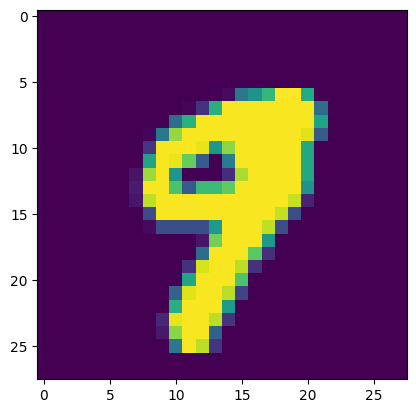

In [ ]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(x_train)

In [ ]:
from collections import defaultdict

POSITIVE_CLASSES = [0]

def balance(x, y, positive_classes):
    assert -1 not in positive_classes

    p_idx = np.where(np.isin(y, positive_classes))[0]
    n_idx = np.where(~np.isin(y, positive_classes))[0]
    len = min(p_idx.shape[0], n_idx.shape[0])
    p_idx = np.random.permutation(p_idx)[:len]
    n_idx = np.random.permutation(n_idx)[:len]
    idx = np.random.permutation(np.concatenate([p_idx, n_idx]))
    x, y = x[idx], y[idx]

    return x, y

X, Y = balance(x_train, y_train, POSITIVE_CLASSES)

def oh_encode(y, positive_classes):
    none = np.array([0.0] * len(positive_classes))

    oh_enc = defaultdict(lambda: none)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(positive_classes):
        cls_vec = np.array([0.0] * len(positive_classes))
        cls_vec[i] = 1.0
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    return oh_dec, np.array([oh_enc[cls] for cls in y])

OH_DEC, Y_oh = oh_encode(Y, [0, 1])
OH_DEC, Y_oh.shape

(defaultdict(<function __main__.oh_encode.<locals>.<lambda>()>,
             {(1.0, 0.0): 0, (0.0, 1.0): 1}),
 (11846, 2))

In [1]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(
    784,
    [
        (1, 'tanh')
    ],
    lr=1.0
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(784)]]
number of parameters 785


In [21]:
def batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]

    input = [list(map(Value, xi)) for xi in X]
    ground_truths = [list(map(Value, yi)) for yi in Y_oh]

    return input, ground_truths

In [75]:
# loss function
def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def decode(values):
    encoded = tuple(np.array([v.data for v in values]).round())
    return OH_DEC[encoded]


def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += decode(score) == decode(ground_truths)

    return matches / len(scores)

def loss(input, ground_truths):
    scores = list(map(model, input))
    total_loss = sum(one_loss(s, gt) for s, gt in zip(scores, ground_truths))

    return scores, total_loss

input, ground_truths = batch(X, Y_oh, 1)
scores, total_loss = loss(input, ground_truths)
acc = accuracy(scores, ground_truths)
total_loss.data, acc


p1 = scores[0][0]._prev.pop()
p11 = p1._prev.pop()
p12 = p1._prev.pop()

In [76]:
p1, p11, p12

(Value(data=213.83172558479868, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=-0.0, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=213.83172558479868, pgrad=0.0, grad=0.0, lr=1.0))

In [42]:
BATCH_SIZE = 16
BATCH = batch(X, Y_oh, BATCH_SIZE)

In [47]:
scores, total_loss = loss(*BATCH)
total_loss.backward()

In [ ]:
model.learn()

In [50]:
parameters = model.parameters()
parameters.sort(key=lambda p: p.data)
[p for p in parameters if p.pgrad != 0.0]

[Value(data=-0.9909611729758714, pgrad=-0.00031941734093139727, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9691586367275093, pgrad=-0.00010893849595942837, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9652278744512504, pgrad=-0.0063576739047396845, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9429148194844058, pgrad=-0.00426983509778356, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.941561672842909, pgrad=-0.03916656709607541, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.937017394983879, pgrad=-1.7483472484043847e-06, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9344410047438966, pgrad=-0.00778346884143476, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9201236544004829, pgrad=-0.005940998455842874, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9195260426339311, pgrad=-0.016308459282438154, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.9135523864590276, pgrad=-3.951176555306835e-07, grad=0.0, lr=1.4142135623730951),
 Value(data=-0.8958447964367614, pgra

In [ ]:
BATCH_SIZE = 16
BATCH = batch(X, Y_oh, BATCH_SIZE)

# optimization
for k in range(3):

    # forward
    total_loss, acc = loss(*BATCH)
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    learning_rate = 1.0
    for p in model.parameters():
        # p.data += -learning_rate * p.grad
        p.learn(0.5)

total_loss, acc = loss(*BATCH)
total_loss.backward()
print(f"final loss {total_loss.data}, accuracy {acc*100}%")